<a href="https://colab.research.google.com/github/sumandutta8877/DATA-Analytics/blob/Jeel/DA_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone 'https://github.com/sumandutta8877/Data_DA.git'    # Run this Line for only one time
!pip install --upgrade scikit-learn

Cloning into 'Data_DA'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.
     |████████████████████████████████| 22.3MB 1.3MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
import pandas as pd
df_train = pd.read_csv('/content/Data_DA/Data/Train_data.csv')
df_test = pd.read_csv('/content/Data_DA/Data/Test_data.csv')
df_sample = pd.read_csv('/content/Data_DA/Data/Sample_submission.csv')

df1 = df_train            # df1 is the training dataframe
df2 = df_test             # df2 is the test dataframe

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection  import RandomizedSearchCV
from sklearn.compose import *
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import *
from sklearn.metrics import balanced_accuracy_score # Evaluation metric 2.0 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import *
from sklearn.linear_model import *
from sklearn.metrics import mean_absolute_error
from sklearn.base import BaseEstimator
from sklearn.tree import *
from sklearn.ensemble import *
from sklearn import set_config
from sklearn.model_selection import cross_val_score

In [4]:
labels = dict(zip([1,2,3,4,5],df1['popularity'].unique()))
df1.loc[(df1['popularity']=='very low'), 'popularity level'] = 1
df1.loc[(df1['popularity']=='low'), 'popularity level'] = 2
df1.loc[(df1['popularity']=='average'), 'popularity level'] = 3
df1.loc[(df1['popularity']=='high'), 'popularity level'] = 4
df1.loc[(df1['popularity']=='very high'), 'popularity level'] = 5

# **Pre-processing**

In [5]:
import datetime as dt
import time as tm
today = dt.date.today()

# On train data set
df1['loudness'] = (-1)*df1['loudness']

df1['mode'] = df1['mode'].apply(lambda x: 1 if x == 'Major' else 0)
df1['explicit'] = df1['explicit'].apply(lambda x: 1 if x == 'Yes' else 0)

df1['release_date'] = pd.to_datetime(df1['release_date'])
df1['Today']=today
df1['Today']=pd.to_datetime(df1['Today'])
df1['days older']= (df1['Today']-df1['release_date']).dt.days



# On test data set
df2['loudness'] = (-1)*df2['loudness']

df2['mode'] = df2['mode'].apply(lambda x: 1 if x == 'Major' else 0)
df2['explicit'] = df2['explicit'].apply(lambda x: 1 if x == 'Yes' else 0)

df2['release_date'] = pd.to_datetime(df2['release_date'])
df2['Today']=today
df2['Today']=pd.to_datetime(df2['Today'])
df2['days older']= (df2['Today']-df2['release_date']).dt.days

In [6]:
df1.head()

,id,acousticness,danceability,energy,explicit,instrumentalness,key,liveness,loudness,mode,release_date,speechiness,tempo,valence,year,duration-min,popularity,popularity level,Today,days older
0,2015,0.949,0.235,0.0276,0,0.9270,5,0.513,27.398,1,1947-01-01,0.0381,110.838,0.0398,1947,3.0,very low,1.0,2021-03-18,27105
1,15901,0.855,0.456,0.4850,0,0.0884,4,0.151,10.046,1,2020-11-13,0.0437,152.066,0.8590,2020,2.4,low,2.0,2021-03-18,125
2,9002,0.827,0.495,0.4990,0,0.0000,0,0.401,8.009,0,1950-01-01,0.0474,108.004,0.7090,1950,2.6,very low,1.0,2021-03-18,26009
3,6734,0.654,0.643,0.4690,0,0.1080,7,0.218,15.917,1,1974-04-30,0.0368,83.636,0.9640,1974,2.4,low,2.0,2021-03-18,17124
4,15563,0.738,0.705,0.3110,0,0.0000,5,0.322,12.344,1,1973-01-01,0.0488,117.260,0.7850,1973,3.4,average,3.0,2021-03-18,17608


In [7]:
df1.columns

Index(['id', 'acousticness', 'danceability', 'energy', 'explicit',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'release_date', 'speechiness', 'tempo', 'valence', 'year',
       'duration-min', 'popularity', 'popularity level', 'Today',
       'days older'],
      dtype='object')

In [8]:
X = df1.drop(columns=['id','release_date','popularity', 'popularity level','Today'])
y = df1['popularity level'].values.ravel()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [10]:
col = X.columns
onehot_cat = ['mode','explicit', 'key', 'year'] # one hot encode these features
con_cat = [i for i in col if i not in onehot_cat] # continuous data

In [11]:
# Creating onehotencoding pipeline, impute most frequent feature if missing
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True))
])

# Standardizing continous data, use nearest neighbors for missing features
con_pipe = Pipeline([
    ('SS', StandardScaler()),
    ('KNN', KNNImputer(n_neighbors=5))
])


# Using column transformer to pack all features together, and assign them as categorial and continous data
preprocessor = ColumnTransformer([
    ('categorical', cat_pipe, onehot_cat),
    ('continuous', con_pipe, con_cat)
])

## **ML MODELS :**

In [12]:
# defining dummy estimator for testing regressors
class DummyEstimator(BaseEstimator):
    "Pass through class, methods are present but do nothing."
    def fit(self): pass
    def score(self): pass

# **1) Ridge Regressor**

In [13]:
# Creating space of candidate learning algorithms and their hyperparameters
alphas = np.linspace(0.05, 0.2, 25) # From various runs, the range of 0.05 to 0.2 seems to perform the best
search_space = [{'regre': [Ridge()], # Actual Estimator
                 'regre__alpha': alphas}] ## Alpha determines how much genalization we want to introduce in the model


# Final pipe for cross validation; quantiletransformer has a number of 300 quantiles. This was decided from multiple runs.\
# Changing from 300 to 1000 shows little impact.
ridge_final_pipe = Pipeline([('preprocessor', preprocessor),
                ('regre', TransformedTargetRegressor(regressor=DummyEstimator(),
                                                         transformer=QuantileTransformer(n_quantiles=300,
                                                         output_distribution='normal')))]) 

# Randomly picking numbers from search space (in this case, alphas) to find the best hyperparameter that performs best
ridge_randcv = RandomizedSearchCV(estimator=ridge_final_pipe, 
                                 param_distributions=search_space, 
                                 n_iter=20,
                                 cv=5,
                                 scoring=['neg_root_mean_squared_error', 'neg_mean_squared_error'],
                                 n_jobs=-1,
                                 verbose=1,
                                 random_state=42,
                                 refit='neg_root_mean_squared_error')

In [14]:
set_config(display='diagram')
ridge_randcv.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('categorical',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(handle_unknown='ignore')),
                                                                                               ('imputer',
                                                                                                SimpleImputer(add_indicator=True,
                                                                                                              strategy='most_frequent'))]),
                                                                               ['mode',
                                                                                'explicit',
                                                                                'key',
                                                                                'year']),
                                                                              ('continuous',
                                                                               Pipeline(steps=[('SS',
                                                                                                StandardScaler()),
                                                                                               ('KNN',
                                                                                                KNNImp...
                   param_distributions=[{'regre': [Ridge(alpha=0.19375000000000003)],
                                         'regre__alpha': array([0.05   , 0.05625, 0.0625 , 0.06875, 0.075  , 0.08125, 0.0875 ,
       0.09375, 0.1    , 0.10625, 0.1125 , 0.11875, 0.125  , 0.13125,
       0.1375 , 0.14375, 0.15   , 0.15625, 0.1625 , 0.16875, 0.175  ,
       0.18125, 0.1875 , 0.19375, 0.2    ])}],
                   random_state=42, refit='neg_root_mean_squared_error',
                   scoring=['neg_root_mean_squared_error',
                            'neg_mean_squared_error'],
                   verbose=1)

In [15]:
### Inspecting all cross-validation results and choose best score (RMSE) and best params.
ridge_randcv.cv_results_

{'mean_fit_time': array([0.10143023, 0.09968557, 0.09931078, 0.10021844, 0.09868202,
        0.09711699, 0.10108066, 0.10475335, 0.09931946, 0.09931054,
        0.09805913, 0.09552169, 0.09803648, 0.09777532, 0.0992312 ,
        0.09845695, 0.10047855, 0.09906187, 0.10024781, 0.10031099]),
 'mean_score_time': array([0.01987329, 0.01724358, 0.01795535, 0.0155643 , 0.01593652,
        0.0161571 , 0.01707115, 0.01599264, 0.01516757, 0.01758904,
        0.01554332, 0.01599507, 0.01637268, 0.0156508 , 0.01582093,
        0.01522465, 0.0158875 , 0.01687951, 0.01555586, 0.01411791]),
 'mean_test_neg_mean_squared_error': array([-0.70113129, -0.70112397, -0.70113819, -0.70111707, -0.70113022,
        -0.70113015, -0.70118573, -0.70113864, -0.7011194 , -0.70122444,
        -0.7011376 , -0.70112797, -0.701124  , -0.70119554, -0.70113594,
        -0.70111961, -0.70112301, -0.70111961, -0.70112212, -0.70111711]),
 'mean_test_neg_root_mean_squared_error': array([-0.83703489, -0.83703049, -0.83703902

In [16]:
ridge_randcv.best_score_

-0.83702634895181

In [17]:
ridge_randcv.best_params_

{'regre': Ridge(alpha=0.19375000000000003),
 'regre__alpha': 0.19375000000000003}

# **2) HuberRegressor**

In [18]:
# Create space of candidate learning algorithms and their hyperparameters
alphas = [0.0001, 0.01, 0.1, 1, 10] ## Similar to Ridge, this is for genalization
eps = [1.1, 1.2, 1.3, 1.4, 1.5] ## This is for adjusting how robust HuberRegressor is to outliers. 
search_space = [{'regre': [HuberRegressor(max_iter=1500)], #using max_iter as 1500 for converging results
                 'regre__alpha': alphas,
                 'regre__epsilon': eps}] 

huber_final_pipe = Pipeline([('preprocessor', preprocessor),
                ('regre', TransformedTargetRegressor(regressor=DummyEstimator(),
                                                         transformer=QuantileTransformer(n_quantiles=300,
                                                         output_distribution='normal')))])
huber_randcv = RandomizedSearchCV(estimator=huber_final_pipe, 
                                 param_distributions=search_space, 
                                 n_iter=10,
                                 cv=5,
                                 scoring=['neg_root_mean_squared_error', 'neg_mean_squared_error'],
                                 n_jobs=-1,
                                 verbose=1,
                                 random_state=42,
                                 refit='neg_root_mean_squared_error')

In [19]:
huber_randcv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('categorical',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(handle_unknown='ignore')),
                                                                                               ('imputer',
                                                                                                SimpleImputer(add_indicator=True,
                                                                                                              strategy='most_frequent'))]),
                                                                               ['mode',
                                                                                'explicit',
                                                                                'key',
                                                                                'year']),
                                                                              ('continuous',
                                                                               Pipeline(steps=[('SS',
                                                                                                StandardScaler()),
                                                                                               ('KNN',
                                                                                                KNNImp...
                                                                         transformer=QuantileTransformer(n_quantiles=300,
                                                                                                         output_distribution='normal')))]),
                   n_jobs=-1,
                   param_distributions=[{'regre': [HuberRegressor(alpha=0.01,
                                                                  epsilon=1.5,
                                                                  max_iter=1500)],
                                         'regre__alpha': [0.0001, 0.01, 0.1, 1,
                                                          10],
                                         'regre__epsilon': [1.1, 1.2, 1.3, 1.4,
                                                            1.5]}],
                   random_state=42, refit='neg_root_mean_squared_error',
                   scoring=['neg_root_mean_squared_error',
                            'neg_mean_squared_error'],
                   verbose=1)

In [20]:
huber_randcv.best_params_

{'regre': HuberRegressor(alpha=0.01, epsilon=1.5, max_iter=1500),
 'regre__alpha': 0.01,
 'regre__epsilon': 1.5}

In [21]:
huber_randcv.best_score_

-0.8645448926956589

# **3) Second Run HuberRegressor**

In [22]:
# Create space of candidate learning algorithms and their hyperparameters
alphas = np.linspace(0.0001, 0.001, 10) # Huber requires the genearlization to be lower than Ridge, 
                                        # trying range of 0.0001 to 0.001
eps = np.linspace(1.4, 1.6, 10) # This is for adjusting how robust HuberRegressor is to outliers. 
search_space = [{'regre': [HuberRegressor(max_iter=1500)], # using max_iter as 1500 for converging results
                 'regre__alpha': alphas,
                 'regre__epsilon': eps}] 

huber_final_pipe = Pipeline([('preprocessor', preprocessor),
                ('regre', TransformedTargetRegressor(regressor=DummyEstimator(),
                                                         transformer=QuantileTransformer(n_quantiles=300,
                                                         output_distribution='normal')))])
huber_randcv2 = RandomizedSearchCV(estimator=huber_final_pipe, 
                                 param_distributions=search_space, 
                                 n_iter=10,
                                 cv=5,
                                 scoring=['neg_root_mean_squared_error', 'neg_mean_squared_error'],
                                 n_jobs=-1,
                                 verbose=1,
                                 random_state=42,
                                 refit='neg_root_mean_squared_error')

In [23]:
huber_randcv2.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('categorical',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(handle_unknown='ignore')),
                                                                                               ('imputer',
                                                                                                SimpleImputer(add_indicator=True,
                                                                                                              strategy='most_frequent'))]),
                                                                               ['mode',
                                                                                'explicit',
                                                                                'key',
                                                                                'year']),
                                                                              ('continuous',
                                                                               Pipeline(steps=[('SS',
                                                                                                StandardScaler()),
                                                                                               ('KNN',
                                                                                                KNNImp...
                                                                  max_iter=1500)],
                                         'regre__alpha': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009, 0.001 ]),
                                         'regre__epsilon': array([1.4       , 1.42222222, 1.44444444, 1.46666667, 1.48888889,
       1.51111111, 1.53333333, 1.55555556, 1.57777778, 1.6       ])}],
                   random_state=42, refit='neg_root_mean_squared_error',
                   scoring=['neg_root_mean_squared_error',
                            'neg_mean_squared_error'],
                   verbose=1)

In [24]:
huber_randcv2.best_params_

{'regre': HuberRegressor(alpha=0.00039999999999999996, epsilon=1.6, max_iter=1500),
 'regre__alpha': 0.00039999999999999996,
 'regre__epsilon': 1.6}

In [25]:
huber_randcv2.best_score_

-0.8596863266626039

# **4) Ensemble Bagging** 

In [26]:
n_est = [100, 150] # num of trees (base_estimators)
max_features = [0.8, 1.0] # features in base_estimators
search_space = [{'bag': [BaggingRegressor(n_jobs=-1)], # Actual Estimator
                 'bag__n_estimators': n_est,
                 'bag__max_features': max_features}]

bag_final_pipe = Pipeline([('preprocessor', preprocessor),
                ('bag', TransformedTargetRegressor(regressor=DummyEstimator(),
                                                         transformer=QuantileTransformer(n_quantiles=300,
                                                         output_distribution='normal')))])                

bag_randcv = RandomizedSearchCV(estimator=bag_final_pipe, 
                                 param_distributions=search_space,
                                 cv=5,
                                 scoring=['neg_root_mean_squared_error', 'neg_mean_squared_error'],
                                 n_jobs=-1,
                                 verbose=1,
                                 random_state=42,
                                 refit='neg_root_mean_squared_error')

In [27]:
bag_randcv.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:289: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('categorical',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(handle_unknown='ignore')),
                                                                                               ('imputer',
                                                                                                SimpleImputer(add_indicator=True,
                                                                                                              strategy='most_frequent'))]),
                                                                               ['mode',
                                                                                'explicit',
                                                                                'key',
                                                                                'year']),
                                                                              ('continuous',
                                                                               Pipeline(steps=[('SS',
                                                                                                StandardScaler()),
                                                                                               ('KNN',
                                                                                                KNNImp...
                                                                         transformer=QuantileTransformer(n_quantiles=300,
                                                                                                         output_distribution='normal')))]),
                   n_jobs=-1,
                   param_distributions=[{'bag': [BaggingRegressor(max_features=0.8,
                                                                  n_estimators=150,
                                                                  n_jobs=-1)],
                                         'bag__max_features': [0.8, 1.0],
                                         'bag__n_estimators': [100, 150]}],
                   random_state=42, refit='neg_root_mean_squared_error',
                   scoring=['neg_root_mean_squared_error',
                            'neg_mean_squared_error'],
                   verbose=1)

In [28]:
bag_randcv.best_score_

-0.7546879035147113

# 5) Ensemble - Random Forest

In [29]:
n_est = [100, 150]
min_samples_split = [2, 5]
min_samples_leaf = [2]
max_depth = [100, 150, 250]
search_space = [{'rf': [RandomForestRegressor(n_jobs=-1)], # Actual Estimator
                 'rf__n_estimators': n_est,
                 'rf__min_samples_split': min_samples_split,
                 'rf__min_samples_leaf': min_samples_leaf,
                 'rf__max_depth': max_depth}]

rf_final_pipe = Pipeline([('preprocessor', preprocessor),
                ('rf', TransformedTargetRegressor(regressor=DummyEstimator(),
                                                         transformer=QuantileTransformer(n_quantiles=300,
                                                         output_distribution='normal')))])                

rf_randcv = RandomizedSearchCV(estimator=rf_final_pipe, 
                                 param_distributions=search_space, 
                                 n_iter=12,
                                 cv=5,
                                 scoring=['neg_root_mean_squared_error', 'neg_mean_squared_error'],
                                 n_jobs=-1,
                                 verbose=1,
                                 random_state=42,
                                 refit='neg_root_mean_squared_error')

In [30]:
rf_randcv.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('categorical',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(handle_unknown='ignore')),
                                                                                               ('imputer',
                                                                                                SimpleImputer(add_indicator=True,
                                                                                                              strategy='most_frequent'))]),
                                                                               ['mode',
                                                                                'explicit',
                                                                                'key',
                                                                                'year']),
                                                                              ('continuous',
                                                                               Pipeline(steps=[('SS',
                                                                                                StandardScaler()),
                                                                                               ('KNN',
                                                                                                KNNImp...
                   param_distributions=[{'rf': [RandomForestRegressor(max_depth=250,
                                                                      min_samples_leaf=2,
                                                                      n_estimators=150,
                                                                      n_jobs=-1)],
                                         'rf__max_depth': [100, 150, 250],
                                         'rf__min_samples_leaf': [2],
                                         'rf__min_samples_split': [2, 5],
                                         'rf__n_estimators': [100, 150]}],
                   random_state=42, refit='neg_root_mean_squared_error',
                   scoring=['neg_root_mean_squared_error',
                            'neg_mean_squared_error'],
                   verbose=1)

In [31]:
rf_randcv.best_score_

-0.754810809647

In [32]:
rf_randcv.best_params_

{'rf': RandomForestRegressor(max_depth=250, min_samples_leaf=2, n_estimators=150,
                       n_jobs=-1),
 'rf__max_depth': 250,
 'rf__min_samples_leaf': 2,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 150}

# **Final Model Evaluation on test set** 

In [33]:
print(f'Ridge Regressor: {round(ridge_randcv.best_score_, 3)}')
print(f'Huber Regressor -1: {round(huber_randcv.best_score_, 3)}')
print(f'Huber Regressor -2: {round(huber_randcv2.best_score_, 3)}')
print(f'Bagging Regressor: {round(bag_randcv.best_score_, 3)}')
print(f'Random Forest Regressor: {round(rf_randcv.best_score_, 3)}')

Ridge Regressor: -0.837
Huber Regressor -1: -0.865
Huber Regressor -2: -0.86
Bagging Regressor: -0.755
Random Forest Regressor: -0.755


In [34]:
bag_randcv.best_params_

{'bag': BaggingRegressor(max_features=0.8, n_estimators=150, n_jobs=-1),
 'bag__max_features': 0.8,
 'bag__n_estimators': 150}

In [35]:
model_final = BaggingRegressor(n_estimators=150, max_features = 0.8, n_jobs=-1)
model_final_pipe = Pipeline([('preprocessor', preprocessor),
                ('bag', TransformedTargetRegressor(regressor=model_final,
                                                         transformer=QuantileTransformer(n_quantiles=300,
                                                         output_distribution='normal')))])
model_final_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent'))]),
                                                  ['mode', 'explicit', 'key',
                                                   'year']),
                                                 ('continuous',
                                                  Pipeline(steps=[('SS',
                                                                   StandardScaler()),
                                                                  ('KNN',
                                                                   KNNImputer())]),
                                                  ['acousticness',
                                                   'danceability', 'energy',
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo',
                                                   'valence', 'duration-min',
                                                   'days older'])])),
                ('bag',
                 TransformedTargetRegressor(regressor=BaggingRegressor(max_features=0.8,
                                                                       n_estimators=150,
                                                                       n_jobs=-1),
                                            transformer=QuantileTransformer(n_quantiles=300,
                                                                            output_distribution='normal')))])

In [37]:
from sklearn.metrics import accuracy_score
# Prediction on test set
y_pred = model_final_pipe.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.6f}")

MAE: 0.607711


(-10.0, 10.0)

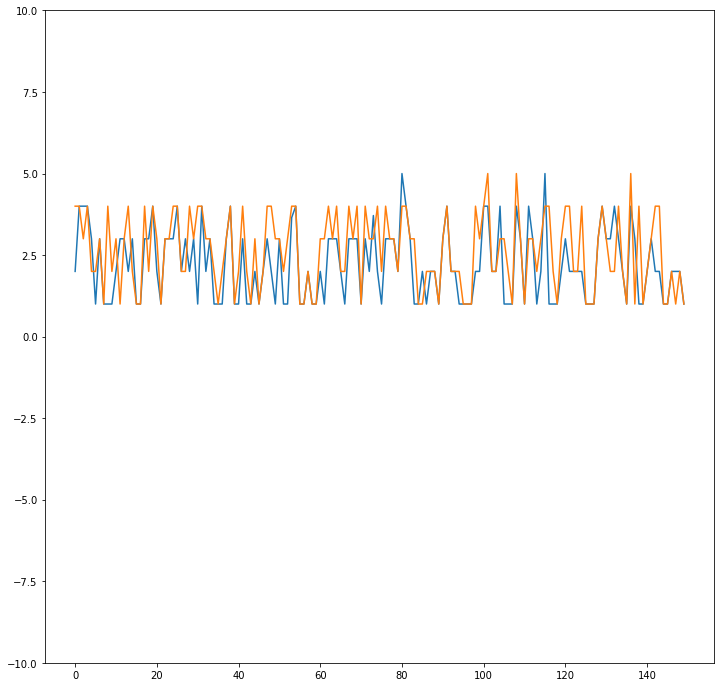

In [74]:
plt.figure(figsize=(12,12))
plt.plot(y_pred[:150],'-',y_test[:150],'-')
plt.ylim(-10,10)

**Evaluation Metric**

Mean absolute error is used to determine how close the predicted popularity score of a song is to the actual populartiy. 